# Your First GAN

### Goal
In this notebook, you're going to create your first generative adversarial network (GAN) for this course! Specifically, you will build and train a GAN that can generate hand-written images of digits (0-9). You will be using PyTorch in this specialization, so if you're not familiar with this framework, you may find the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) useful. The hints will also often include links to relevant documentation.

### Learning Objectives
1.   Build the generator and discriminator components of a GAN from scratch.
2.   Create generator and discriminator loss functions.
3.   Train your GAN and visualize the generated images.


## Getting Started
You will begin by importing some useful packages and the dataset you will use to build and train your GAN. You are also provided with a visualizer function to help you investigate the images your GAN will create.


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](MnistExamples.png)

You may notice that the images are quite pixelated -- this is because they are all only 28 x 28! The small size of its images makes MNIST ideal for simple training. Additionally, these images are also in black-and-white so only one dimension, or "color channel", is needed to represent them (more on this later in the course).

#### Tensor
You will represent the data using [tensors](https://pytorch.org/docs/stable/tensors.html). Tensors are a generalization of matrices: for example, a stack of three matrices with the amounts of red, green, and blue at different locations in a 64 x 64 pixel image is a tensor with the shape 3 x 64 x 64.

Tensors are easy to manipulate and supported by [PyTorch](https://pytorch.org/), the machine learning library you will be using. Feel free to explore them more, but you can imagine these as multi-dimensional matrices or vectors!

#### Batches
While you could train your model after generating one image, it is extremely inefficient and leads to less stable training. In GANs, and in machine learning in general, you will process multiple images per training step. These are called batches.

This means that your generator will generate an entire batch of images and receive the discriminator's feedback on each before updating the model. The same goes for the discriminator, it will calculate its loss on the entire batch of generated images as well as on the reals before the model is updated.

## Generator
The first step is to build the generator component.

You will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to map to another shape, a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for stabilization, and finally a non-linear activation function (you use a [ReLU here](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) so the output can be transformed in complex ways. You will learn more about activations and batch normalization later in the course.

In [2]:
def get_generator_block(input_dim, output_dim, with_batch_norm = True):#`with_batch_norm` is set
                                                                       # True by default to main
                                                                       # -tain original behaviour.
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
        with_batch_norm: if true adds a batch normalization layer
                        else does not add one, bool
                        default: Tru
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization (if `batch_norm` == True 
          else no batch normalization applied) and then a relu activation
    '''
    if with_batch_norm:
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(inplace=True)
        )

In [3]:
def test_gen_block(in_features, out_features, with_batch_norm = True, num_test=1000): 
    '''
    Function to test the generator block created by `get_generator_block`.
    Parameters:
        input_features: the dimension of the input vector, a scalar
        output_features: the dimension of the output vector, a scalar
        num_test: the number of test cases to pass to the generated block, a scalar
        with_batch_norm: if true tests the block with batch normalization
                        else it tests the block w/o batch normalization, bool
                        default: True
    Returns:
        None
        Raises AssertionError if any test fails.
    '''
    block = get_generator_block(in_features, out_features, with_batch_norm)

    # Check the networks' parts
    if with_batch_norm:
        assert len(block) == 3
        assert type(block[0]) == nn.Linear
        assert type(block[1]) == nn.BatchNorm1d
        assert type(block[2]) == nn.ReLU
    else:
        assert len(block) == 2
        assert type(block[0]) == nn.Linear
        assert type(block[1]) == nn.ReLU
        
    # Check the output shape
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    if with_batch_norm:
        assert test_output.std() > 0.55
        assert test_output.std() < 0.65

In [4]:
# Verify the generator block function without batch normalization
test_gen_block(25, 12, with_batch_norm = False)
test_gen_block(15, 28, with_batch_norm = False)
print("Success!")

Success!


In [5]:
# Verify the generator block function with batch normalization
test_gen_block(25, 12)
test_gen_block(15, 28)
print("Success!")

Success!


Now you can build the generator class. It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). You will need to fill in the code for final layer since it is different than the others. The final layer does not need a normalization or activation function, but does need to be scaled with a [sigmoid function](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html). 

Finally, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">Generator</font></code></b>
</font>
</summary>

1. The output size of the final linear transformation should be im_dim, but remember you need to scale the outputs between 0 and 1 using the sigmoid function.
2. [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and [nn.Sigmoid](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html) will be useful here. 
</details>


In [6]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128, with_batch_norm = True):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim, with_batch_norm),
            get_generator_block(hidden_dim, hidden_dim * 2, with_batch_norm),
            get_generator_block(hidden_dim * 2, hidden_dim * 4, with_batch_norm),
            get_generator_block(hidden_dim * 4, hidden_dim * 8, with_batch_norm),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [7]:
def test_generator(z_dim, im_dim, hidden_dim, with_batch_norm = True, num_test=10000):
    '''
    Function to test the generator network created by `Generator`.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
        num_test: the number of test cases to pass to the generated block, a scalar
        with_batch_norm: if true tests the block with batch normalization
                        else it tests the block w/o batch normalization, bool
                        default: True
    Returns:
        None
        Raises AssertionError if any test fails.
    '''
    gen = Generator(z_dim, im_dim, hidden_dim, with_batch_norm).get_gen()
    
    # Check there are six modules in the sequential part
    assert len(gen) == 6
    assert str(gen.__getitem__(4)).replace(' ', '') == f'Linear(in_features={hidden_dim * 8},out_features={im_dim},bias=True)'
    assert str(gen.__getitem__(5)).replace(' ', '') == 'Sigmoid()'
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    if with_batch_norm:
        assert test_output.std() > 0.05, "Don't use batchnorm here"
        assert test_output.std() < 0.15, "Don't use batchnorm here"

In [8]:
# Verifying the generator function without batch normalization
test_generator(5, 10, 20, with_batch_norm = False)
test_generator(20, 8, 24, with_batch_norm = False)
print("Success!")

Success!


In [9]:
# Verifying the generator function with batch normalization
test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


## 2D Generators

In this section I will expand on the 1D generators built the previous section, with the same code structure and defined functions, to build the 2D generative network.

I will first make a `get_generator_block_2d` and `test_gen_block_2d` to perform the same function as their 1D counterpart, and then will build at the end of the next section, where the whole network is built in the original notebook (before any of my edits), the entire generative network and test it, in compliance with the workflow suggested by the notebook.

In [10]:
def get_generator_block_2d(in_channels, out_channels, kernel_size, stride=1, padding=0):
    '''
    Function for returning a block of the 2d generator's neural network
    given input and output dimensions.
    The blok returned uses ConvTranspose2d and BatchNorm2d in building. 
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
        with_batch_norm: if true adds a batch normalization layer
                        else does not add one, bool
                        default: True
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization (if `batch_norm` == True 
          else no batch normalization applied) and then a relu activation
    '''
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels)
    )

In [11]:
def test_gen_block_2d(in_channels, out_channels, kernel_size, stride, padding, num_test = 1000):
    '''
    Function to test the generator network created by `Generator`.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
        num_test: the number of test cases to pass to the generated block, a scalar
        with_batch_norm: if true tests the block with batch normalization
                        else it tests the block w/o batch normalization, bool
                        default: True
    Returns:
        None
        Raises AssertionError if any test fails.
    '''
    block = get_generator_block_2d(in_channels, out_channels, kernel_size, stride, padding)

    # Check the networks' parts
    assert len(block) == 2
    assert type(block[0]) == nn.ConvTranspose2d    
    assert type(block[1]) == nn.BatchNorm2d
        
    # Check the output shape
    test_input = torch.randn(num_test, in_channels, 1, 1)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_channels, kernel_size, kernel_size)

In [12]:
# Verify the 2d generator block with batch normalization
test_gen_block_2d(25, 12, 4, 1, 0)
test_gen_block_2d(15, 28, 4, 1, 0)
print("Success!")

Success!


__`Generator2d`__ class, which implements batch normalization and spectral normalization, depending on the value of the parameter `norm_type`.

In [13]:
class Generator2d(nn.Module):
    '''
    CNN Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        hidden_chan_depth: the inner dimension of channel depths, a scalar
    '''
    def __init__(self, z_dim=10, hidden_chan_depth=64):
        super(Generator2d, self).__init__()
        
        
        
        self.gen = nn.Sequential(
            get_generator_block_2d(z_dim, hidden_chan_depth * 4, 4, 1, 0),
            get_generator_block_2d(hidden_chan_depth * 4, hidden_chan_depth * 2, 4, 2, 1),
            get_generator_block_2d(hidden_chan_depth * 2, hidden_chan_depth , 4, 2, 2),
            
            nn.ConvTranspose2d(hidden_chan_depth, 1, 4, 2, 1)
        )
        
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [14]:
def test_generator_2d(z_dim, hidden_dim, num_test = 1000):
    '''
    Function to test the generator network created by `Generator2d`.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
        num_test: the number of test cases to pass to the generated block, a scalar
        with_batch_norm: if true tests the block with batch normalization
                        else it tests the block w/o batch normalization, bool
                        default: True
    Returns:
        None
        Prints out "Success!" if all test passed succefully.
    '''
    gen = Generator2d(z_dim, hidden_dim).get_gen()
    
    # Check there are six modules in the sequential part
    assert len(gen) == 4
    test_input = torch.randn(num_test, z_dim, 1, 1)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, 1, 28, 28), f' output shape not correct. Expected output size: ({num_test}, 1, 28, 28) got instead {test_output.shape}'

In [15]:
# Verifying the generator function
test_generator_2d(5, 10, 20)
test_generator_2d(20, 8, 24)
print("Success!")

Success!


## Noise
To be able to use your generator, you will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. You will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, you will generate all the noise vectors at once.

Note that whenever you create a new tensor using torch.ones, torch.zeros, or torch.randn, you either need to create it on the target device, e.g. `torch.ones(3, 3, device=device)`, or move it onto the target device using `torch.ones(3, 3).to(device)`. You do not need to do this if you're creating a tensor by manipulating another tensor or by using a variation that defaults the device to the input, such as `torch.ones_like`. In general, use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros` where possible.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">get_noise</font></code></b>
</font>
</summary>

1. 
You will probably find [torch.randn](https://pytorch.org/docs/master/generated/torch.randn.html) useful here.
</details>

In [16]:
def get_noise(n_samples, z_dim, net_dim = 1, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        net_dim: either 1 or 2 for noise suitable for 1-d or 2-d GAN's respectively, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    if net_dim == 1:
        return torch.randn(n_samples,z_dim,device=device)
    elif net_dim == 2:
        return torch.randn(n_samples,z_dim, 1, 1, device=device)
    else:
        raise ValueError('Unexpected value for variable net_dim, either 1 or 2 allowed.')
    #### END CODE HERE ####

In [17]:
# Verify the noise vector function
def test_get_noise(n_samples, z_dim, net_dim = 1, device='cpu'):
    noise = get_noise(n_samples, z_dim, net_dim, device)
    
    # Make sure a normal distribution was used
    if net_dim == 1:
        assert tuple(noise.shape) == (n_samples, z_dim)
        assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
        assert str(noise.device).startswith(device)
    else:
        assert tuple(noise.shape) == (n_samples, z_dim, 1, 1)
        assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
        assert str(noise.device).startswith(device)

In [18]:
test_get_noise(1000, 100, 1, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
print("Success!")

Success!


In [19]:
test_get_noise(1000, 100, 2, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
print("Success!")

Success!


## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.

*Note: You use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient. You will learn more about this in the following lectures!* 


REctified Linear Unit (ReLU) |  Leaky ReLU
:-------------------------:|:-------------------------:
![](relu-graph.png)  |  ![](lrelu-graph.png)





In [20]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )

In [21]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)
    
    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5
    
    assert str(block.__getitem__(0)).replace(' ', '') == f'Linear(in_features={in_features},out_features={out_features},bias=True)'        
    assert str(block.__getitem__(1)).replace(' ', '').replace(',inplace=True', '') == 'LeakyReLU(negative_slope=0.2)'


test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


Now you can use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that you do not need a sigmoid after the output layer since it is included in the loss function. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [22]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [23]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):
    
    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4
    assert type(disc.__getitem__(3)) == nn.Linear

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

Success!


## 2D Discriminator

In this section I will build the 2d discriminator that I will train against the 2d generator created in the expanded section __2D Generator__.

For a convolutional layer with input and output depths of n, m respectively, there are m x n weight matrices each from one input channel to one output channel. I have chosen to normalize each weight matrix seperately, this made more sense to me although this was not clear to me from the sources I have reviewed when implementing the algorithm.

This makes more sense as each matrix is its own logical entity, capturing a certain pattern from an input channel and sending it through the network to an output channel. So, normalizing accross different matrices might cause some features to drop completely if their average weights where smaller than average weights of other matrices depecting other feature, which, I suspect, will affect the training of the discriminator negatively.

Furthermore, normalizing will constrain the values, and their gradients, wether it is applied matrix by matrix or on the entire layer all together. So, I chose to treat them seperately for the reason mentioned prior.

In [24]:
class SpectNorm2d(nn.Module):
    '''
    A class implementation of spectral normalization, for Conv2d layers.
    This class treats the weight matrix of each channel seperately; each matrix has its own
    u and v vectors and is normalized according to its corresponding sigma seperately.
    Values:
        module: nn.Conv2d or nn.ConvTranspose2d layer (I didn't consider any other layer
        in the implementation)
        name: the name of the weights to apply spectral normalization on, str
        n_power_iterations: how many times to iterate on u and v before normalizing the weights, int (> 0)
        eps: epsilon (very small value) added when normalizing vectors for stability, float
    '''
    def __init__(self, module, name = 'weight', n_power_iterations = 1, eps=1e-12):
        super().__init__()
        self.module = module
        # trying to access `name` in `module` to make sure it is a valid attribute
        # this is irrelavent for the purposes of this code but there is not much
        # overhead loss in some more general the better.
        if hasattr(self.module, str(name)):
            self.name = name
        else:
            raise ValueError(f'{name} is not an attribute of {module}.')
        
        # making sure `n_power_iterations` makes sense
        if n_power_iterations <= 0:
            raise ValueError(f'Expected n_power_iterations to be positive, but got n_power_iterations={n_power_iterations}')
        else:
            self.n_power_iterations = n_power_iterations
        
        self.eps = eps
        # prepare necessary parameters to perform the algorithm
        if not self._params_made():
            self._make_params()
            
    def _make_params(self):
        w = getattr(self.module, self.name)
        
        vector_shape = list(w.data.shape[:-1])
        vector_shape.append(1)
        vector_shape = torch.Size(vector_shape)
        
        u = nn.Parameter(w.data.new(vector_shape).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(vector_shape).normal_(0, 1), requires_grad=False)
        u.data = self._l2normalize(u.data)
        v.data = self._l2normalize(v.data)
        w_bar = nn.Parameter(w.data)
        
        del self.module._parameters[self.name] # not needed before forward pass
                                               # and updated in _updated_params
        self.module.register_parameter('u', u)
        self.module.register_parameter('v', v)
        self.module.register_parameter(self.name + '_bar', w_bar)
    
    def _update_u_v(self):
        u = getattr(self.module, 'u')
        v = getattr(self.module, 'v')
        w = getattr(self.module, self.name + '_bar')
        
        for _ in range(self.n_power_iterations):
            v.data = self._l2normalize(torch.matmul(w.data.transpose(-2, -1), u.data))
            u.data = self._l2normalize(torch.matmul(w.data, v.data))
            
        # calculating sigma for each matrix
        sigma = torch.mul(u, torch.matmul(w, v)).norm(dim=[-1, -2])[:,:,None,None]
        setattr(self.module, self.name, torch.div(w, sigma))
    
    def _params_made(self):
        return (hasattr(self.module, 'u') 
            and hasattr(self.module, 'v')
            and hasattr(self.module, self.name + '_bar')
               )
    
    def _l2normalize(self, v):
        # normalizing over the seperate vectors corresponding to each weight matrix
        # not over the whole weight tensor, only for eahc channel-to-channel matrix
        return torch.div(v, (v.norm(dim=[-1, -2])[:,:,None,None] + self.eps))  
    
    
    def forward(self, x):
        self._update_u_v()
        x = self.module(x)
        return x

In [25]:
def test_l2normalize(v):
    pass

In [26]:
def test_update_u_v():
    pass

In [27]:
def get_discriminator_block_2d(in_channels, out_channels, kernel_size,
                               n_power_interations, norm_type = 'spect'):
    '''
    2D Discriminator Block
    Function for returning a neural network of the discriminator given # input channels and output channels,
    kernel_size, stride, and padding.
    Parameters:
        in_channels: the dimension of the input vector, a scalar
        out_channels: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, preceeded by a ReLU and normalized
        using spectral normalization module implemented here.
    '''
    if norm_type == 'spect':
        return nn.Sequential(
            nn.ReLU(inplace=True),
            SpectNorm2d(nn.Conv2d(in_channels, out_channels, kernel_size),
                        n_power_iterations = n_power_interations),
            nn.MaxPool2d(2, 2)
        )
    elif norm_type == 'batch':
        return nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2, 2)
        )

In [28]:
def test_disc_block_2d(im_side, in_channels, out_channels, kernel_size,
                       n_power_interations,
                       num_test=100):
    block = get_discriminator_block_2d(in_channels, out_channels, kernel_size,
                                    n_power_interations)

    # Check there are 3 parts
    assert len(block) == 3
    test_input = torch.randn(num_test, in_channels, im_side, im_side)
    test_output = block(test_input)

    # Check that the shape is right
    out_im_side = int(im_side/2) - 1
    assert tuple(test_output.shape) == (num_test, out_channels, out_im_side, out_im_side),\
    f'Expected output size ({num_test}, {out_channels}, {out_im_side}, {out_im_side}), instead got {test_output.shape}'

In [29]:
test_disc_block_2d(30, 1, 8, 3, 2)
test_disc_block_2d(15, 2, 16, 3, 2)
print("Success!")

Success!


In [37]:
class Discriminator2d(nn.Module):
    '''
    CNN Discriminator Class
    Values:
        in_channels: the dimension of the input vector, a scalar
        out_channels: the dimension of the output vector, a scalar
        n_power_interations = number of iterations to perform in spectral normalization, int
        does not affect running if norm_type = 'batch'
        norm_type: 'spect' or 'batch' the type of normalization used, str
    '''
    def __init__(self, in_channels = 1, hidden_chan_depth = 16, n_power_interations = 2, norm_type = 'spect'):
        super(Discriminator2d, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block_2d(in_channels, hidden_chan_depth * 2, 3,
                                       n_power_interations, norm_type),
            get_discriminator_block_2d(hidden_chan_depth * 2, hidden_chan_depth * 4, 3,
                                       n_power_interations, norm_type)
        )            
        
        # calculate image side after passing through disc
        # maxpool layer is set to half image side each step
        im_side = 28
        for _ in range(2):
            im_side /= 2
            im_side -= 1
        im_side = int(im_side)
        
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(hidden_chan_depth * 4 * im_side * im_side, hidden_chan_depth * 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_chan_depth * 2, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_side)
        '''
        image = self.disc(image).view(image.shape[0], -1)
        return self.classifier(image)
    
    def get_levels(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc, self.classifier

In [38]:
# Verify the discriminator class
def test_discriminator_2d(in_channels, hidden_chan_depth, n_power_interations, num_test=100):
    
    model = Discriminator2d(in_channels, hidden_chan_depth, n_power_interations)
    disc, classifier = model.get_levels()
    
    # Check disc part
    assert len(disc) == 2
    
    # Check classifier
    assert len(classifier) == 4
    
    # Check the linear layer is correct
    test_input = torch.randn(num_test, in_channels, 28, 28)
    test_output = model(test_input)
    assert tuple(test_output.shape) == (num_test, 1),\
    f'Expected output size ({num_test}, 1), instead got {test_output.shape}'

In [39]:
test_discriminator_2d(5, 50, 2)
test_discriminator_2d(20, 28, 2)
print("Success!")

Success!


## Training
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.



In [56]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 5 # instead of 200 for the purposes of testing
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = ('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [57]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If you use `torch.ones` or `torch.zeros`, you'll need to pass `device=device` to them.

In [42]:
def get_disc_loss(gen, disc, net_dim, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    fake_noise = get_noise(num_images, z_dim, net_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [45]:
def test_disc_reasonable(num_images=10, net_dim = 1):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    if net_dim == 1:
        real = torch.ones(num_images, 1)
    else:
        real = torch.ones(num_images, z_dim, num_images, 1)
    disc_loss = get_disc_loss(gen, disc, net_dim, criterion, real, num_images, z_dim, 'cpu')
    if net_dim == 1:
        assert tuple(disc_loss.shape) == (num_images, z_dim), f'Expected shape ({num_images}, {z_dim}), instead got {disc_loss.shape}'
    assert torch.all(torch.abs(disc_loss - 0.5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, net_dim, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)

def test_disc_loss(max_tests = 10, net_dim = 1):
    z_dim = 64
    if net_dim == 1:
        gen = Generator(z_dim).to(device)
        disc = Discriminator().to(device) 
    else:
        gen = Generator2d(z_dim).to(device)
        disc = Discriminator2d().to(device) 
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, net_dim, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

In [46]:
test_disc_reasonable()
test_disc_loss()
print("Success!")

AssertionError: 

In [47]:
def get_gen_loss(gen, disc, net_dim, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    fake_noise = get_noise(num_images, z_dim, net_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    #### END CODE HERE ####
    return gen_loss

In [48]:
def test_gen_reasonable(num_images = 10, net_dim = 1):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, net_dim, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    if net_dim == 1:
        assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss(gen, disc, net_dim, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    if net_dim == 1:
        assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss(num_images, net_dim = 1):
    z_dim = 64
    if net_dim == 1:
        gen = Generator(z_dim).to(device)
        disc = Discriminator().to(device) 
    else:
        gen = Generator2d(z_dim).to(device)
        disc = Discriminator2d().to(device) 
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss(gen, disc, net_dim, criterion, num_images, z_dim, device)
    
    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))

In [49]:
test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


Finally, you can put everything together! For each epoch, you will process the entire dataset in batches. For every batch, you will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess. 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and something you will see more of in later lectures and assignments.

After you've submitted a working version with the original architecture, feel free to play around with the architecture if you want to see how different architectural choices can lead to better or worse GANs. For example, consider changing the size of the hidden dimension, or making the networks shallower or deeper by changing the number of layers.

<!-- In addition, be warned that this runs very slowly on a CPU. One way to run this more quickly is to use Google Colab: 

1.   Download the .ipynb
2.   Upload it to Google Drive and open it with Google Colab
3.   Make the runtime type GPU (under “Runtime” -> “Change runtime type” -> Select “GPU” from the dropdown)
4.   Replace `device = "cpu"` with `device = "cuda"`
5.   Make sure your `get_noise` function uses the right device -->

But remember, don’t expect anything spectacular: this is only the first lesson. The results will get better with later lessons as you learn methods to help keep your generator and discriminator at similar levels.

You should roughly expect to see this progression. On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes:
![MNIST Digits](MNIST_Progression.png)

In [50]:
def train(gen, disc, gen_opt, disc_opt, net_dim = 1):
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    test_generator = True # Whether the generator should be tested
    gen_loss = False
    error = False      
        
    for epoch in range(n_epochs):

        # Dataloader returns the batches
        for real, _ in tqdm(dataloader):
            cur_batch_size = len(real)

            # Flatten the batch of real images from the dataset
            if net_dim == 1:
                real = real.view(cur_batch_size, -1).to(device)

            ### Update discriminator ###
            # Zero out the gradients before backpropagation
            disc_opt.zero_grad()

            # Calculate discriminator loss
            disc_loss = get_disc_loss(gen, disc, net_dim, criterion, real, cur_batch_size, z_dim, device)

            # Update gradients
            disc_loss.backward(retain_graph=True)

            # Update optimizer
            disc_opt.step()

            # For testing purposes, to keep track of the generator weights
            if test_generator:
                old_generator_weights = gen.gen[0][0].weight.detach().clone()

            ### Update generator ###
            #     Hint: This code will look a lot like the discriminator updates!
            #     These are the steps you will need to complete:
            #       1) Zero out the gradients.
            #       2) Calculate the generator loss, assigning it to gen_loss.
            #       3) Backprop through the generator: update the gradients and optimizer.
            #### START CODE HERE ####
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, net_dim, criterion, cur_batch_size, z_dim, device)
            gen_loss.backward()
            gen_opt.step()
            #### END CODE HERE ####

            # For testing purposes, to check that your code changes the generator weights
            if test_generator:
                try:
                    assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                    assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
                except:
                    error = True
                    print("Runtime tests have failed")

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0 and cur_step > 0:
                print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                fake_noise = get_noise(cur_batch_size, z_dim, net_dim, device=device)
                fake = gen(fake_noise)
                show_tensor_images(fake)
                show_tensor_images(real)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.4364656784534453, discriminator loss: 0.42439733606576907


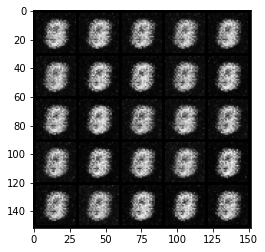

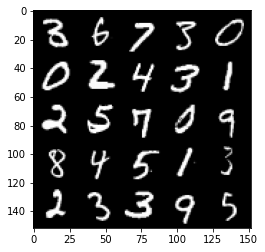

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.7308689029216764, discriminator loss: 0.2902692148685454


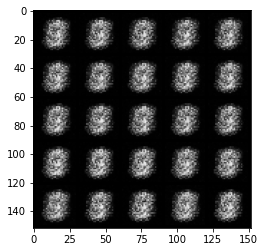

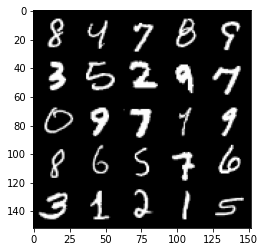

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.060319923400877, discriminator loss: 0.16554672470688814


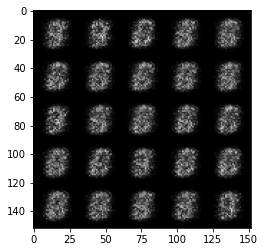

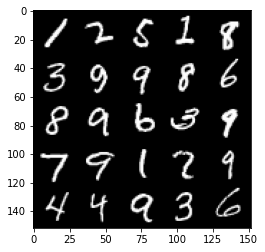

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.7422017002105712, discriminator loss: 0.21564976945519437


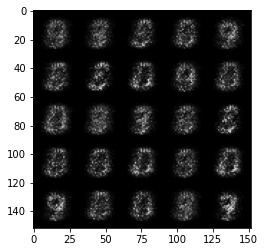

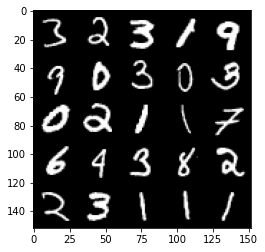

In [58]:
# training linear with batch normalization
train(gen, disc, gen_opt, disc_opt)

In [59]:
# Training Linear (without batch normalization)
gen = Generator(z_dim, with_batch_norm = False).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.0810721677541737, discriminator loss: 0.5046594834327693


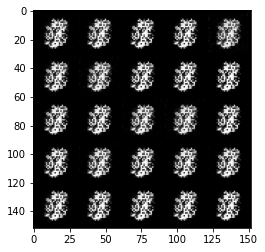

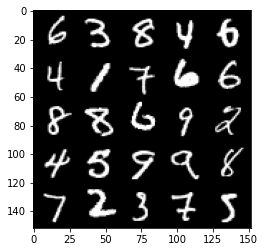

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.0825934007167815, discriminator loss: 0.5422167218923569


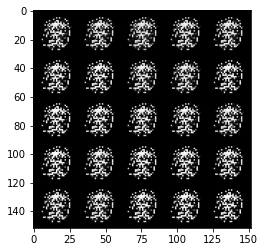

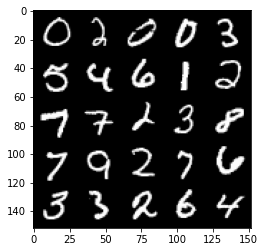

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.083865805864334, discriminator loss: 0.4906474645137788


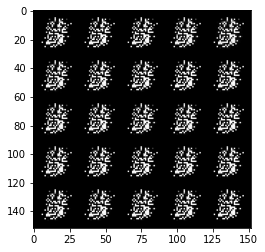

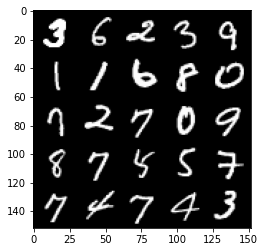

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.2199278142452246, discriminator loss: 0.49496684682369213


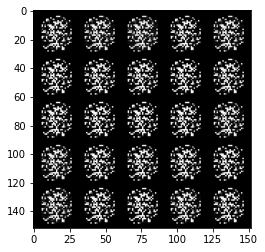

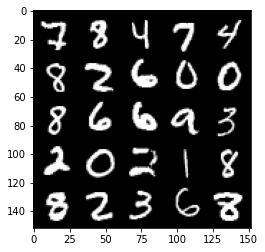

In [60]:
train(gen, disc, gen_opt, disc_opt)

## 2D Integration Testing And Training

Here I will use the testing and training functions defined above to test the 1-d generator and disriminator, to test and train the 2-d networks I have built using `nn.Conv2d`, `nn.ConvTranspose2d`, and `SpectNorm2d`.

I have already refactored code from the previous training and testing section, in order to reuse it for testing and training the 2d model by just calling the already defined functions. So, to perform testing and training I will only call the appropriate functions.

I have added the parameter `net_dim`, to the noise generating function, and all functions in the previous section. This parameter tells the functions wether the network being tested or trained the originally supplied with the file, the 1-d network, or the one I have implemented, the 2-d network.

`net_dim = 1` uses the original generator and disriminator.

`net_dim = 2` uses my netowrks.

In [63]:
# with spectral normalization
gen = Generator2d(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator2d().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500: Generator loss: 6.859045148849477, discriminator loss: 0.11135816399753093


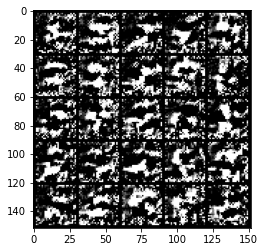

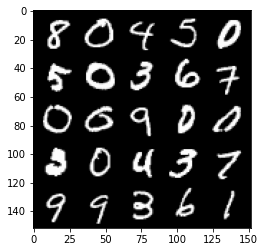

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 3.70208605670929, discriminator loss: 0.2333258280456065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


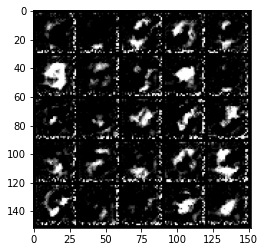

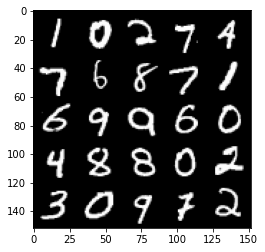

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500: Generator loss: 1.3265301795005804, discriminator loss: 0.44248107522726043


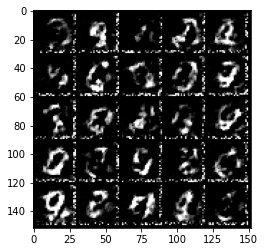

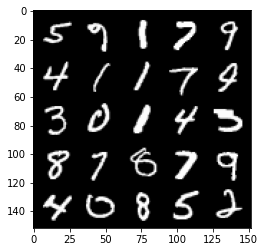

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 1.7800853815078719, discriminator loss: 0.3138450891673564


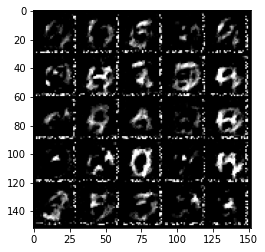

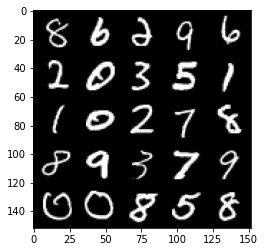

In [64]:
train(gen, disc, gen_opt, disc_opt, net_dim = 2)

In [65]:
# with batch normalization
gen = Generator2d(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator2d(norm_type = 'batch').to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500: Generator loss: 0.9120698781013488, discriminator loss: 0.5499473266601554


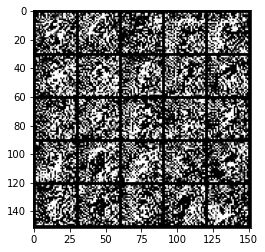

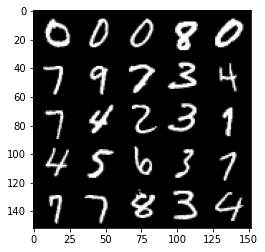

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.9371849632263183, discriminator loss: 0.5097141672968867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


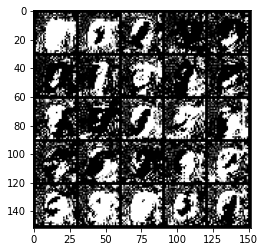

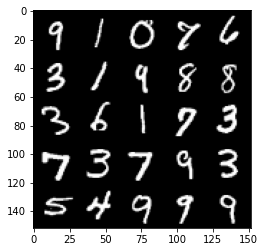

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500: Generator loss: 1.0880386031866076, discriminator loss: 0.4310694230794907


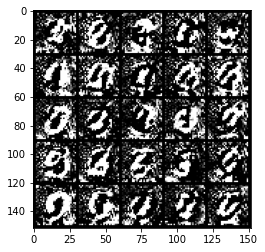

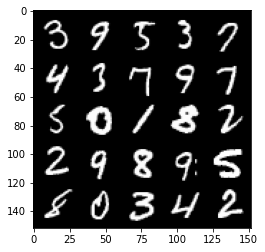

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 1.3682351913452153, discriminator loss: 0.336677251815796


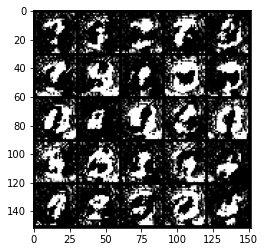

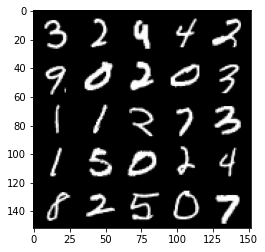

KeyboardInterrupt: 

In [66]:
train(gen, disc, gen_opt, disc_opt, net_dim = 2)

## Comments on Results

In the linear model performs much better with batch normalization, at least in the first few demostrated epochs. Although the generator without batch normalization have smaller losses, I think this might be because it seems to combine some elements of each (circular shaped from zero and some lines from other numbers) and consequently can perform better against the discriminator. 

For the CNN GAN's the plotted images get better much faster, the spectral normalization version still performs better with the same amount of training. And losses behave as expected, mostly deceasing over epochs.

## Comments on Completeness of Code

Due to time constraints I could not complete all tests and make the code more reusable, so I focused on the important aspects.